Reference paper: [Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Jauvin. 2003. A Neural Probabilistic Language Model. J. Mach. Learn. Res. 3, (February 2003), 1137–1155.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

One main difference in our implementation is that we are working with characters instead of words. The vocabulary size in the Bengio's paper is 17,000 words, whereas we are going to have a vocabulary of 27 characters (26 characters and the `<.>` special character).

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open("./names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vacabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
s2i = {s: i + 1 for i, s in enumerate(chars)}
s2i["."] = 0
i2s = {i: s for s, i in s2i.items()}
vocab_size = len(i2s)
print(i2s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3  # context length

def build_dataset(words):
    x, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = s2i[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]  # crop and append

    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_trn, y_trn = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_tst, y_tst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))  # total number of parameters in the model
for p in parameters:
    p.requires_grad = True

11897


How can we find a good startint point for the learning rate?

In [7]:
lre = []
lrs = []
tracker = []
max_steps = 1_000
bs = 32

for e in torch.linspace(-3, 0, max_steps):
    lrs.append(10**e)
    lre.append(e)
    
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
for step in range(max_steps):
    # minibatch
    ix = torch.randint(0, x_trn.shape[0], (bs,))
    xs = x_trn[ix]
    ys = y_trn[ix]
    lr = lrs[step]

    # forward pass
    emb = C[xs]  # (32, 3, 2)
    h = torch.tanh(
        emb.view((emb.shape[0], -1)) @ W1 + b1
    )  # (32, 100)... also tanh is important to not get inf loss!
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, ys)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    tracker.append(loss.item())

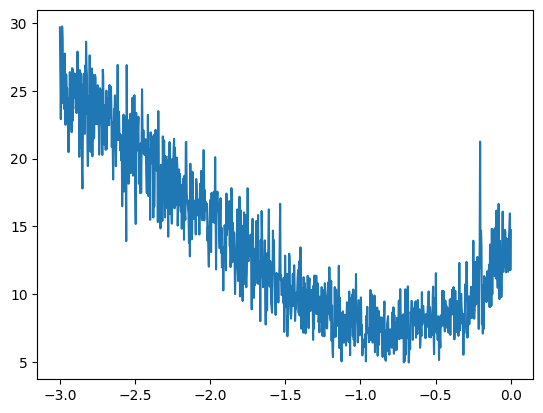

In [8]:
plt.plot(lre, tracker)

Using the LR Finder first proposed by [Leslie Smith](https://arxiv.org/abs/1506.01186), $ 10^{-1} $ seems like a good starting point.

In [9]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))  # total number of parameters in the model
for p in parameters:
    p.requires_grad = True

11897


In [10]:
bs = 32
lr = 0.1
n_steps = 200_000

steps = []
lrs = []
losses = []

for step in range(n_steps):
    # minibatch
    ix = torch.randint(0, x_trn.shape[0], (bs,))
    xs = x_trn[ix]
    ys = y_trn[ix]

    # forward pass
    emb = C[xs]  # (32, 3, 10)
    h = torch.tanh(
        emb.view((emb.shape[0], -1)) @ W1 + b1
    )  # (32, 100)... also tanh is important to not get inf loss!
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, ys)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step lr decay
    if step == 100_000:
        lr /= 10
        print(f"---> new lr: {lr}")
    
    # update    
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    steps.append(step)
    lrs.append(lr)
    losses.append(loss.log10().item())

---> new lr: 0.01


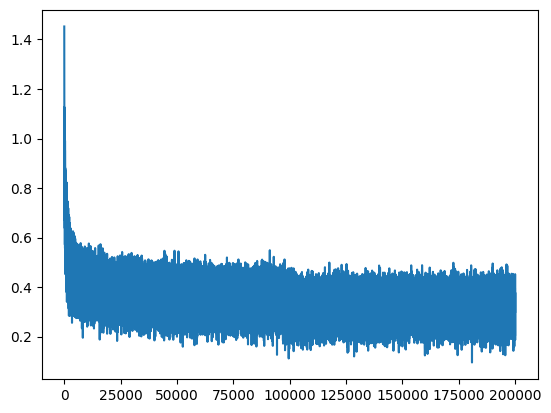

In [11]:
plt.plot(steps, losses)
ax = plt.gca()
plt.show()

In [12]:
emb = C[x_trn]  # (32, 3, 2)
h = torch.tanh(
    emb.view((-1, 30)) @ W1 + b1
)  # (32, 100)... also tanh is important to not get inf loss!
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, y_trn)
loss

tensor(2.1123, grad_fn=<NllLossBackward0>)

Let's validate the quality of our model on the validation set.

In [13]:
emb = C[x_val]  # (32, 3, 2)
h = torch.tanh(
    emb.view((-1, 30)) @ W1 + b1
)  # (32, 100)... also tanh is important to not get inf loss!
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.1512, grad_fn=<NllLossBackward0>)

In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print("".join(i2s[i] for i in out))

mohaammyah.
see.
mad.
rylle.
emmadiendraeg.
aderedieli.
jemi.
jen.
eden.
van.
nar.
elle.
malke.
cayshabergiairiel.
kindreth.
konnie.
con.
brence.
ryyah.
fael.


This generated names are better than those generated by the bigram model, although not that good yet.